# [LAB-01] 비지도학습 > 군집분석 > KMeans > 활용예제

## #01.준비작업
### [1] 패키지 참조

In [33]:
# 라이브러리 기본 참조
from hossam import load_data,my_dpi
from pandas import DataFrame,get_dummies,merge

from matplotlib import pyplot as plt
from matplotlib import font_manager as fm

import seaborn as sb
import numpy as np

# 클러스터링 관련 참조
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial import ConvexHull


#Elbow Point 계산 라이브러리
from kneed import KneeLocator

#정규성 검정 라이브러리
from scipy.stats import normaltest

#데이터 전처리 라이브러리
from sklearn.preprocessing import StandardScaler,OneHotEncoder

#실루엣 스코어 라이브러리
from sklearn.metrics import silhouette_samples,silhouette_score
my_dpi = 200

### [2] 데이터 가져오기


In [34]:
origin = load_data('customer')

print("\n==== 데이터 크기 확인 ====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n==== 타입확인 ====")
print(origin.info())


다음의 데이터는 어느 백화점의 고객에 대한 성별,나이,연수입,지출점수를 조사한 가상 데이터

==== 데이터 크기 확인 ====
데이터셋 크기: (200, 5)
열 개수: 5
행 개수: 200

==== 타입확인 ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   고객ID    200 non-null    int64 
 1   성별      200 non-null    object
 2   나이      200 non-null    int64 
 3   연수입     200 non-null    int64 
 4   지출점수    200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


## #02. 데이터 탐색 및 전처리
### [1] 인덱스 지정

In [35]:
df = origin.set_index('고객ID')
df.head()

,성별,나이,연수입,지출점수
고객ID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


### [2] 정규분포 여부 확인
- 머신러닝에서 K-MEANS 군집화 진행 시엔 데이터가 정규성을 충족해야함
- 충족하지 않으면 스케일링 적용 필요

In [36]:
fields = ['나이','연수입','지출점수']

for f in fields:
  stat,p = normaltest(df[f])
  alpha = 0.05
  print(f'\n ===== {f} 정규성 검정 =====')
  print(f'stat={stat},p={p}')
  if p>alpha:
    print(f'{f}는 정규분포를 따릅니다 (귀무가설 채택)')
  else:
    print(f'{f}는 정규분포를 따르지 않습니다 (귀무가설 기각)')


 ===== 나이 정규성 검정 =====
stat=15.577514003752057,p=0.000414367622180182
나이는 정규분포를 따르지 않습니다 (귀무가설 기각)

 ===== 연수입 정규성 검정 =====
stat=3.5109953115353187,p=0.17282121541298148
연수입는 정규분포를 따릅니다 (귀무가설 채택)

 ===== 지출점수 정규성 검정 =====
stat=16.302230221326983,p=0.0002884135672001835
지출점수는 정규분포를 따르지 않습니다 (귀무가설 기각)


### [3] 정규분포를 따르지 않는 데이터가 존재하여, 표준화 적용


In [37]:
scale_df = df[['나이','연수입','지출점수']].copy()
scaler = StandardScaler()
sdf= DataFrame(
  scaler.fit_transform(scale_df) , columns=scale_df.columns,index=scale_df.index
)

sdf.insert(0,'성별',df['성별'])
sdf

,성별,나이,연수입,지출점수
고객ID,,,,
1,Male,-1.424569,-1.738999,-0.434801
2,Male,-1.281035,-1.738999,1.195704
3,Female,-1.352802,-1.700830,-1.715913
4,Female,-1.137502,-1.700830,1.040418
5,Female,-0.563369,-1.662660,-0.395980
...,...,...,...,...
196,Female,-0.276302,2.268791,1.118061
197,Female,0.441365,2.497807,-0.861839
198,Male,-0.491602,2.497807,0.923953


### [3] 명목형 변수 인코딩

<K-Means 에서 범주형 변수를 처리하는 방법>
- (1) 순서형 : 리커트 척도 -> 라벨 인코딩 (1,2,3,) | 변수간 우월관계가 존재하므로 연속형 처럼 써도 무방함
- (2) 명목형 : 성별 , 지역 -> 원-핫 인코딩 (drop first 하지 않음)

* 선형모델에서는 다중 공선성 문제 때문에 drop first 를 요구함
* 변수 사이에 우월관계나 순서가 없는데, drop first 를 하게되면 참조 변수가 하나 사라지면서, 
* 유클리디안 거리 계산을 적용했을 때 참조변수와 다른 변수들간의 거리가 유독 가깝게 계산되면서 왜곡될 수 있음


#### (1) pandas 기능의 get dummies 를 통한 인코딩



In [38]:
df_dummies = get_dummies(sdf,columns = ['성별'] , dtype = 'int',drop_first=False)
df_dummies.head()

,나이,연수입,지출점수,성별_Female,성별_Male
고객ID,,,,,
1,-1.424569,-1.738999,-0.434801,0,1
2,-1.281035,-1.738999,1.195704,0,1
3,-1.352802,-1.700830,-1.715913,1,0
4,-1.137502,-1.700830,1.040418,1,0
5,-0.563369,-1.662660,-0.395980,1,0


#### (2) sklearn 기능을 사용한 인코딩

In [39]:
X = df[['성별']]

encoder = OneHotEncoder(sparse_output=False , drop=None)  # drop None 설정
result = encoder.fit_transform(X)
result[:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [40]:
new_cols = encoder.get_feature_names_out(['성별'])
new_cols

array(['성별_Female', '성별_Male'], dtype=object)

In [41]:
#DataFrame 병합
one_hot_df = DataFrame(result,columns=new_cols,index=df.index)
one_hot_df.head()

,성별_Female,성별_Male
고객ID,,
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0


In [42]:
df_copy =df.copy()
df_encode = merge(df_copy , one_hot_df , left_index=True,right_index=True)

df_encode = df_encode.drop(columns=['성별'])
df_encode.head()

,나이,연수입,지출점수,성별_Female,성별_Male
고객ID,,,,,
1,19,15,39,0.0,1.0
2,21,15,81,0.0,1.0
3,20,16,6,1.0,0.0
4,23,16,77,1.0,0.0
5,31,17,40,1.0,0.0


## #03. 엘보우 포인트 구하기
### [1] 적절한 범위 내에서 이너셔 값 생성
- 최소 군집수와 최대 군집수는 분석가의 주관으로 결정
- 스케일링 된 변수로 넣어야 inertia 가 적정 범위에서 나온다

In [43]:
klist = list(range(3,11))
inertia = [] # inertia 값을 저장할 리스트

for k in klist:
  estimator = KMeans(n_clusters = k , random_state=52)
  estimator.fit(X=df_dummies)
  inertia.append(estimator.inertia_)


inertia

[393.5986115835211,
 304.3074053388816,
 284.3453955595961,
 245.03129918573325,
 237.7227000085023,
 197.75874820044876,
 173.3303339679523,
 163.9166081964125]

### [2] 최적의 k 값, 엘보우포인트 도출
- 스케일링한 데이터를 사용하게되면 과하게 압축되다보니 민감도를 극대화하는 S 파라미터 추가 권장 > 엘로우 포인트 k 가 내려갈 수 있음

In [44]:
kl = KneeLocator(klist,inertia,curve='convex',direction='decreasing',S=0.1)
best_k=kl.elbow
best_y=kl.elbow_y
print('found elbow' , best_k)
print('found y' , best_y)

found elbow 4
found y 304.3074053388816


### [3] 시각화 확인

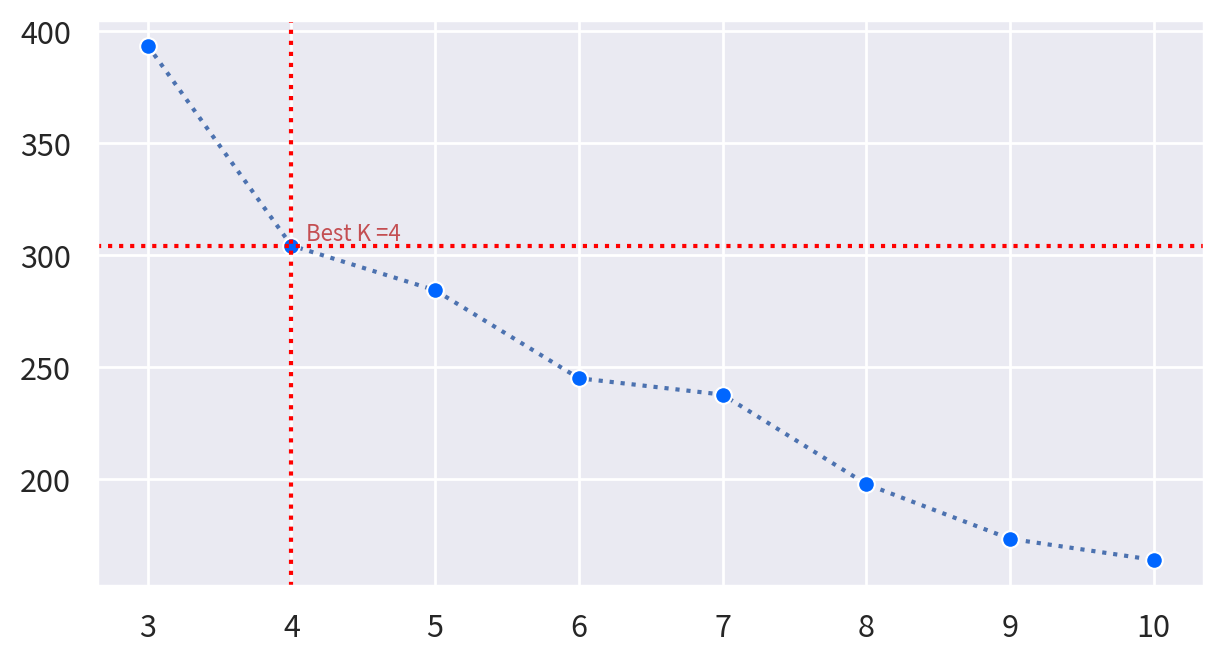

In [45]:
# 1) 그래프 초기화
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) Line Plot 그리기
sb.lineplot(x=klist, 
            y=inertia, 
            linestyle =':',
            marker ='o',
            markerfacecolor ='#0066ff' , 
            markeredgecolor='#ffffff')

#엘보우 포인트 표시
ax.axvline(x=best_k,color='red',linestyle=':')
ax.axhline(y=best_y,color='red',linestyle=':')
ax.text(
  best_k + 0.1,
   best_y + 0.1,
  'Best K =%d' % best_k,
  fontsize=8,
  ha='left',
  va='bottom',
  color='r'

)


# 3) 그래프 꾸미기
ax.grid(True)                 # 배경 격자 표시/숨김

# 4) 출력
plt.tight_layout()            # 여백 제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료


## [4] 엘보우 포인트 검증 (실루엣 스코어)

### [1] 실루엣스코어 시각화 함수 정의

In [46]:
def visualize_silhouette(estimator, X_features):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

    sil_avg = silhouette_score(X=X_features, labels=estimator.labels_)
    sil_values = silhouette_samples(X=X_features, labels=estimator.labels_)

    y_lower = 10
    plt.suptitle(
        "Number of Cluster : " + str(estimator.n_clusters) + ", "
        "Silhouette Score :" + str(round(sil_avg, 3))
    )
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_features) + (estimator.n_clusters + 1) * 10])
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.grid()

    # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
    for i in range(estimator.n_clusters):
        ith_cluster_sil_values = sil_values[estimator.labels_ == i]
        ith_cluster_sil_values.sort()

        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / estimator.n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_sil_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.axvline(x=sil_avg, color="red", linestyle="--")

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(estimator.labels_.astype(float) / estimator.n_clusters)
    ax2.scatter(
        X_features[X_features.columns[0]],
        X_features[X_features.columns[1]],
        marker="o",
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor="k",
    )

    # Labeling the clusters
    centers = estimator.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="r",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    ax2.grid()

    plt.show()
    plt.close()

### [2] 군집수별 실루엣 스코어 확인

In [52]:
#시작값은 최조 군집수
klist = list(range(3,11))
silhouette = []  #실루엣 스코어를 저장할 리스트

for k in klist:
  estimator = KMeans(n_clusters=k,random_state=52)
  estimator.fit(X=df_dummies)
  cluster = estimator.predict(df_dummies)
  s_score = silhouette_score(X=df_dummies,labels=cluster)
  silhouette.append(s_score)


silhouette_df = DataFrame({'k':klist , 'silhouette_score' : silhouette})
silhouette_df

,k,silhouette_score
0,3,0.287876
1,4,0.318743
2,5,0.295763
3,6,0.309651
4,7,0.298297
5,8,0.313272
6,9,0.339913
7,10,0.336890


#### 최적의 k 값 및 근거

- ⭐ **최적의 k는 4로 선택하는 것이 타당함**
  - 엘보우 포인트가 4에서 도출되어 군집의 응집도가 급격히 완화되는 지점임
  - 실루엣 스코어도 k=4에서 0.318로, 전체 구간 중 가장 높은 값에 근접함

- ☑️ **실루엣 스코어의 해석**
  - k=4에서 실루엣 스코어가 가장 높지는 않지만(최고값은 k=9, 0.339),
    k가 커질수록 군집의 해석력과 실용성이 떨어질 수 있음
  - 실루엣 스코어가 0.3 이상이면 군집 품질이 양호한 편임

- 📌 **결론**
  - 엘보우 포인트와 실루엣 스코어를 모두 고려할 때,
    k=4가 군집의 응집도와 해석력, 실용성 측면에서 최적임
  - 데이터의 특성과 분석 목적에 따라 k=4를 선택하는 것이 가장 합리적임

## #05. 최종 모형
### [1] 군집분석

In [54]:
estimator = KMeans(n_clusters=6,random_state =52)
estimator.fit(X=df_dummies)
clusters=estimator.predict(df_dummies)


cdf = df_dummies.copy()
cdf['ClusterID'] = clusters
cdf.head()

,나이,연수입,지출점수,성별_Female,성별_Male,ClusterID
고객ID,,,,,,
1,-1.424569,-1.738999,-0.434801,0,1,1
2,-1.281035,-1.738999,1.195704,0,1,5
3,-1.352802,-1.700830,-1.715913,1,0,1
4,-1.137502,-1.700830,1.040418,1,0,5
5,-0.563369,-1.662660,-0.395980,1,0,1


### [2] 군집 결과 시각화

- (기존 방식) x_field = '연수입' , y_field = '지출점수' 이런식으로 컬럼명을 직접 지정했음
- (수정 방식) x_field = cdf.columns[1] , y_field = cdf.columns[2] 컬럼을 순서 인덱스로 지정
KMEANS가 학습에 사용한 X 의 컬럼 순서 그대로 중심점이 저장된다


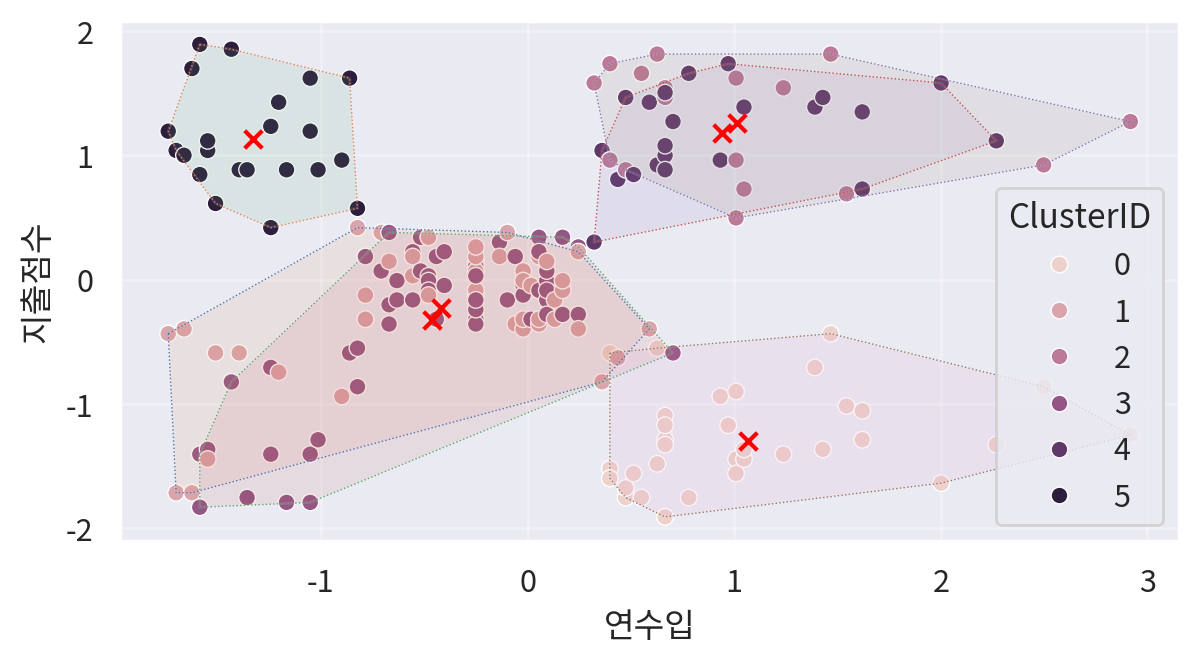

In [56]:
vdf = cdf.copy()
hue_field ='ClusterID'
x_field =cdf.columns[1]    #연수입
y_field = cdf.columns[2] #지출점수

# 1) 그래프 초기화
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


#데이터 산점도
sb.scatterplot (data=vdf , x=x_field , y=y_field , hue=hue_field)



# 군집별 값의 종류별로 반복문 실행
for c in vdf[hue_field].unique():
  #값의 종류별로 데이터 프레임 구분
  df_c = vdf.loc[vdf[hue_field] == c , [x_field,y_field]]

  try:
    #외각선 좌표 계산
    hull = ConvexHull(df_c)

    #마지막 좌표 이후에 첫번쨰 좌표를 연결
    points = np.append(hull.vertices,hull.vertices[0])

    ax.plot( #type:ignore
      df_c.iloc[points,0] , df_c.iloc[points,1] , linewidth = 0.5 , linestyle =':'
      )
    
    ax.fill(df_c.iloc[points,0] , df_c.iloc[points ,1], alpha =0.1)


  except:
    pass

#군집별 중심점 표시
ax.scatter(
  estimator.cluster_centers_[:,1],   #연수입의 인덱스
  estimator.cluster_centers_[:,2],   #지출점수의 인덱스
  marker='x',
  c='red',
  alpha=1,
  s=40
)


ax.grid(True ,alpha =0.3) #배경 격자 표시
plt.tight_layout()
plt.show()
plt.close()

#### 나이에 따른 지출 점수

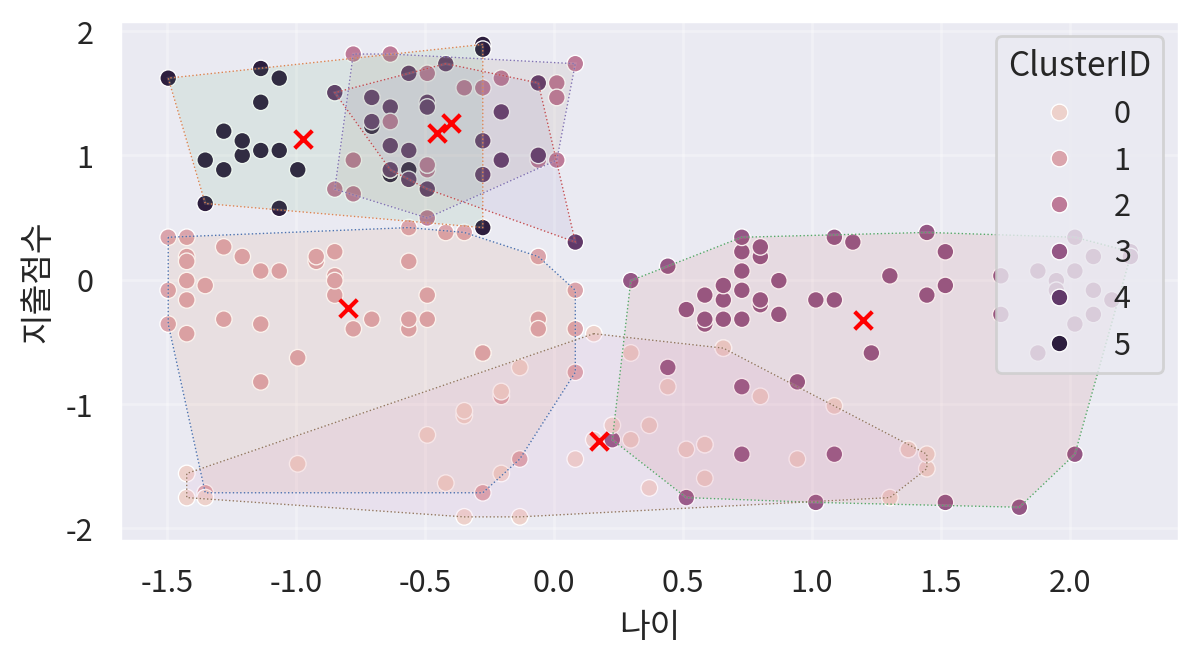

In [57]:
vdf = cdf.copy()
hue_field ='ClusterID'
x_field =cdf.columns[0]    #나이
y_field = cdf.columns[2] #지출점수

# 1) 그래프 초기화
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
rows = 1                     # 그래프 행 수
cols = 1                     # 그래프 열 수
my_dpi=200

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)


#데이터 산점도
sb.scatterplot (data=vdf , x=x_field , y=y_field , hue=hue_field)



# 군집별 값의 종류별로 반복문 실행
for c in vdf[hue_field].unique():
  #값의 종류별로 데이터 프레임 구분
  df_c = vdf.loc[vdf[hue_field] == c , [x_field,y_field]]

  try:
    #외각선 좌표 계산
    hull = ConvexHull(df_c)

    #마지막 좌표 이후에 첫번쨰 좌표를 연결
    points = np.append(hull.vertices,hull.vertices[0])

    ax.plot( #type:ignore
      df_c.iloc[points,0] , df_c.iloc[points,1] , linewidth = 0.5 , linestyle =':'
      )
    
    ax.fill(df_c.iloc[points,0] , df_c.iloc[points ,1], alpha =0.1)


  except:
    pass

#군집별 중심점 표시
ax.scatter(
  estimator.cluster_centers_[:,0],   #나이의 인덱스
  estimator.cluster_centers_[:,2],   #지출점수의 인덱스
  marker='x',
  c='red',
  alpha=1,
  s=40
)


ax.grid(True ,alpha =0.3) #배경 격자 표시
plt.tight_layout()
plt.show()
plt.close()

## #06 페르소나 분석 - 군집 결과 활용 마케팅 대상 도출

### [1] 원본 데이터에 클러스터링 결과 접목

In [58]:
pdf = origin.copy()
pdf['ClusterID'] = cluster
pdf.drop('고객ID',axis=1,inplace=True)
pdf.head()

,성별,나이,연수입,지출점수,ClusterID
0,Male,19,15,39,9
1,Male,21,15,81,9
2,Female,20,16,6,1
3,Female,23,16,77,4
4,Female,31,17,40,1


- 단순히 평균으로만 판단하지 않고, 데이터의 성격에 따라 가장 적절한 대표값을 찾아보자

### [2] 집단별 대표값 산출

In [59]:
persona_list = []

for i in range(best_k):
    cluster_data = pdf[pdf["ClusterID"] == i]
    # display(cluster_data.head())
    # continue

    persona_item = {"Cluster": i}

    for column in cluster_data.columns:
        # print(column)
        
        # continue
        if column == "ClusterID":
            continue
        elif column == "성별":
            # 값의 종류별로 카운트 {남: 123, 여: 77}
            # 값이 가장 큰 항목의 인덱스를 추출
            persona_item[f"{column}"] = cluster_data[column].value_counts().idxmax()
        else:
            stat, p = normaltest(cluster_data[column])
            alpha = 0.05

            if p > alpha:
                mean_value = cluster_data[column].mean()
                persona_item[f"{column}"] = mean_value
            else:
                median_value = cluster_data[column].median()
                persona_item[f"{column}"] = median_value
    
    persona_list.append(persona_item)

persona_df = DataFrame(persona_list)
persona_df.sort_values(by="Cluster", inplace=True)
persona_df

,Cluster,성별,나이,연수입,지출점수
0,0,Female,46.444444,91.722222,21.055556
1,1,Female,28.533333,51.433333,42.000000
2,2,Male,33.277778,82.500000,82.666667
3,3,Female,52.575758,47.484848,47.000000
